In [99]:
### Distance Matrix to MDS

### Get data

In [100]:
import pandas as pd
import numpy as np

In [101]:
### Import distance matrix and remove Row labels
df = pd.read_table("Data/ssRNA_complete_genomes_100_subsample_50000.dist")
df = df.drop("#query", axis=1)
### Get filenames from headers
INDEX = list(df)
print(len(INDEX))

3900


### Get metadata

In [102]:
import pandas as pd
df_Accessions_100 = pd.read_csv("Data/df_ssRNA_complete_100_subsample.tsv", sep="\t")
len(df_Accessions_100)

3900

In [103]:
Acc_to_species = dict(zip(df_Accessions_100["accs"], df_Accessions_100["species"]))

In [104]:
import pickle
with open('Data/Accessions_100.pickle', 'rb') as handle:
    Accessions = pickle.load(handle)
len(Accessions)

3900

In [105]:
Sub_positions = []
Sub_accessions = []
for Acc in INDEX:
    if Acc in Accessions:
        Sub_positions.append(int(INDEX.index(Acc)))
        Sub_accessions.append(Acc)
print(len(Sub_positions))

3900


In [106]:
Sub_species = []
for Acc in Sub_accessions:
    Sub_species.append(Acc_to_species[Acc])

In [107]:
Submatrix = df.iloc[Sub_positions, Sub_positions]

### Run DBSCAN

In [108]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [109]:
def Run_Multi_DBSCAN(
                        Labels_true, 
                        Distances, 
                        EPS_low        = 0.01, 
                        EPS_high       = 0.1, 
                        EPS_incr       = 0.01, 
                        Min_group_low  = 5, 
                        Min_group_high = 10, 
                        Min_group_incr = 1
                    ):


    Run_scores =          [[
                            "Min_group",
                            "Epsilon",
                            "n_clusters_",
                            "n_outliers_",
                            "Run_score",
                            "Homogeneity_score",
                            "Completeness_score"
                         ]]
    
    All_Class_metadata = [[
                            'Epsilon',
                            'Min_group',
                            "Class",
                            "Num_members",
                            "Num_clustered_members",
                            "Num_outlier_members",
                            "Num_clusters",
                            "Class_score",
                            "Clusters"
                        ]]
    for Min_group in range(int(Min_group_low), int(Min_group_high)+int(Min_group_incr), int(Min_group_incr)):
        for Epsilon in range(int(EPS_low * 1000), int(EPS_high * 1000) + int(EPS_incr * 1000), int(EPS_incr * 1000)):
            Run_score, Class_metadata = Run_DBSCAN(Distances, Labels_true, Epsilon * 0.001, Min_group)
            Run_scores.append(Run_score)
            All_Class_metadata.append(Class_metadata)
    return Run_scores, All_Class_metadata

In [110]:
from Modules.Distance_Matrix_DBScan import Run_DBSCAN

In [111]:
Distances = Submatrix.values
labels_true = Sub_species
# db = DBSCAN(eps=float(.16), min_samples= int(9), metric='precomputed').fit(Distances)

In [112]:
%%capture
Run_scores, All_Class_metadata = Run_Multi_DBSCAN(
                                                    labels_true,
                                                    Distances,
                                                    EPS_low        = 0.001, 
                                                    EPS_high       = 1.0, 
                                                    EPS_incr       = 0.001, 
                                                    Min_group_low  = 5, 
                                                    Min_group_high = 10, 
                                                    Min_group_incr = 1
                                                )

In [113]:
Run_scores = pd.DataFrame(Run_scores[1:], columns=Run_scores[0])

In [124]:
Run_scores.to_csv("Data/df_ssRNA_complete_genomes_100_subsample_50000_DBSCAN_Run_scores.tsv", sep="\t")

In [120]:
All_Class_metadata2 = []
for Entry in All_Class_metadata[1:]:
    for E in Entry:
        All_Class_metadata2.append(E)
df_All_Class_metadata = pd.DataFrame(All_Class_metadata2, columns=All_Class_metadata[0])

In [123]:
df_All_Class_metadata.to_csv("Data/df_ssRNA_complete_genomes_100_subsample_50000_DBSCAN_per_class_scoring.tsv", sep="\t")

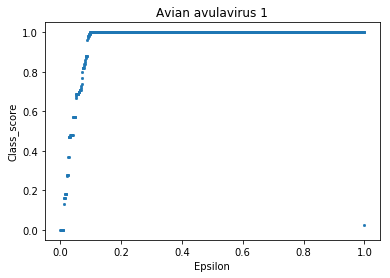

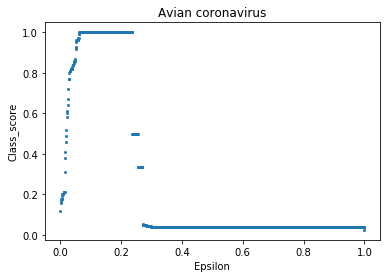

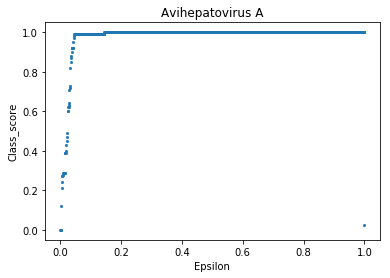

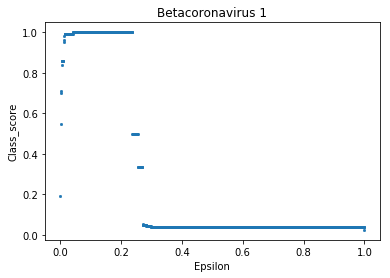

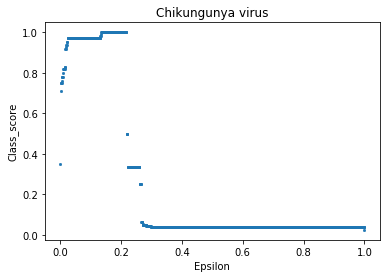

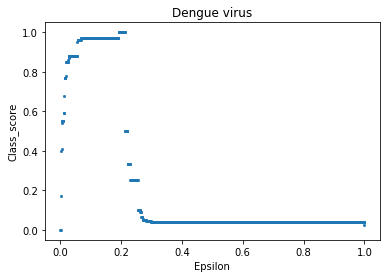

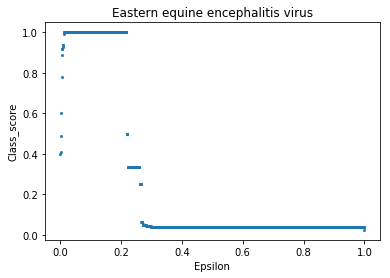

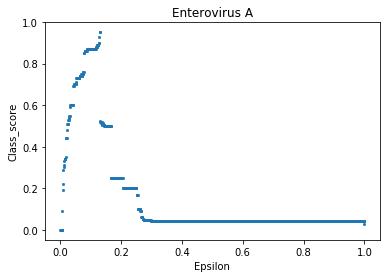

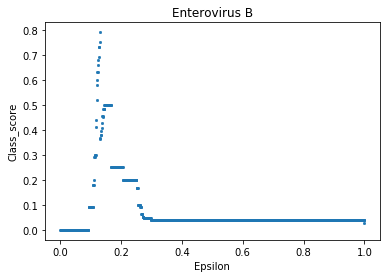

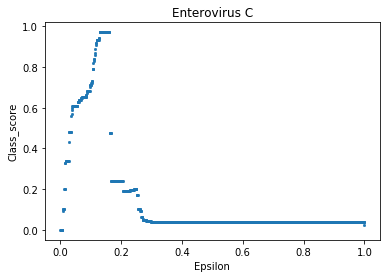

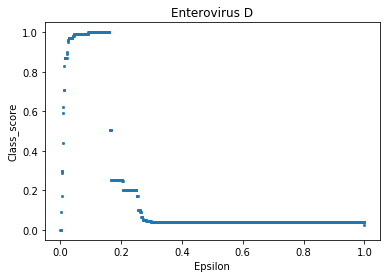

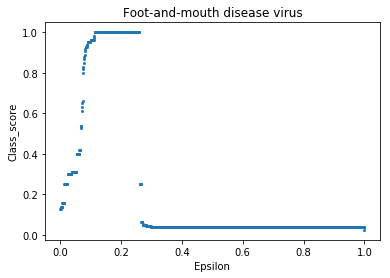

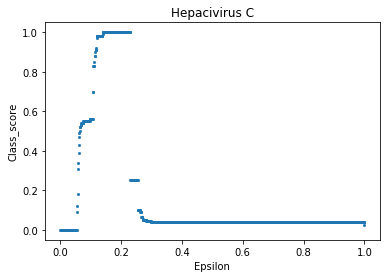

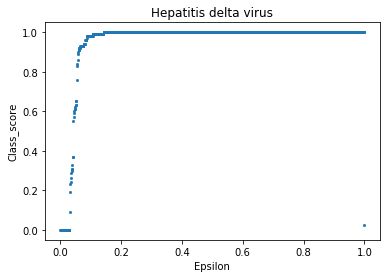

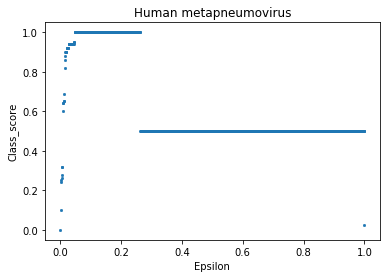

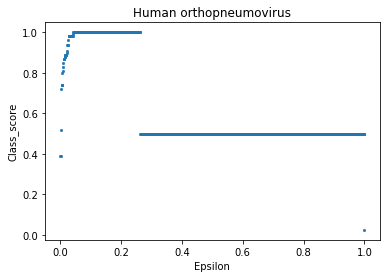

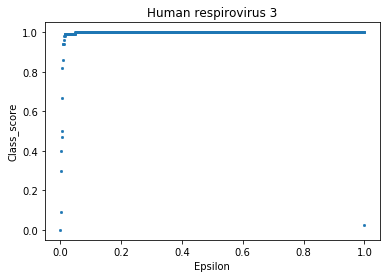

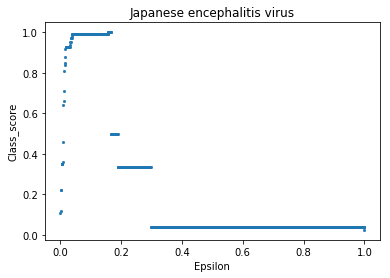

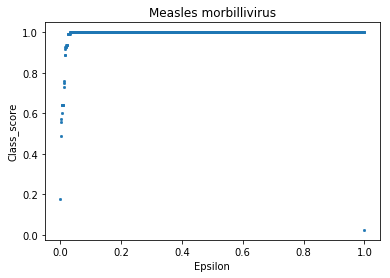

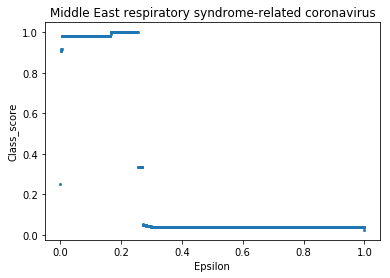

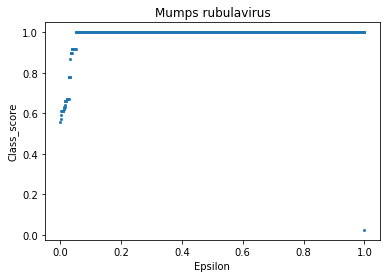

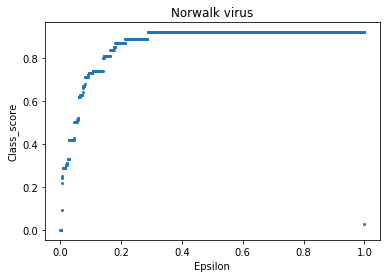

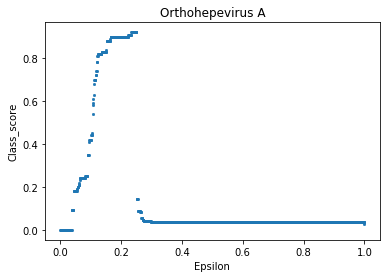

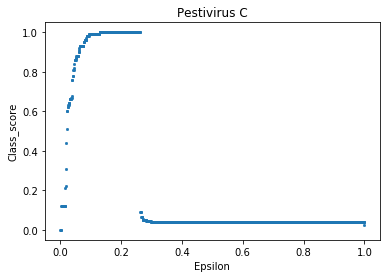

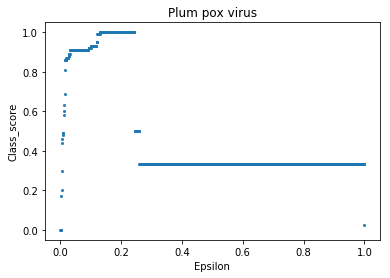

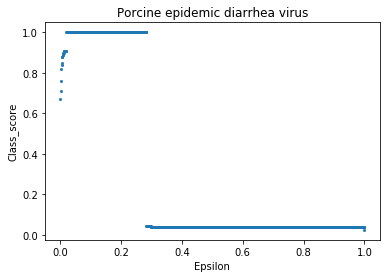

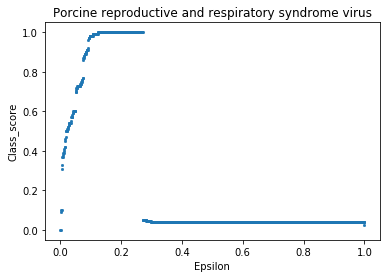

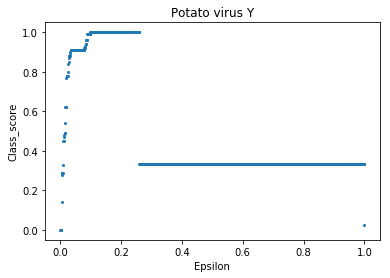

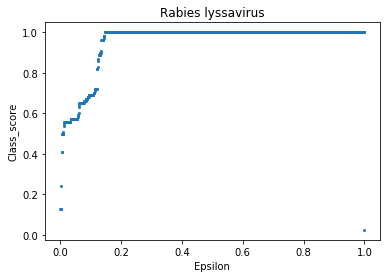

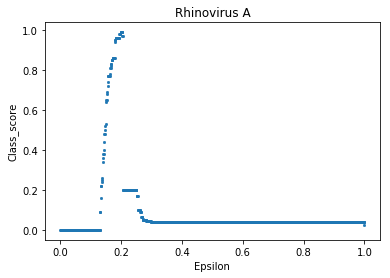

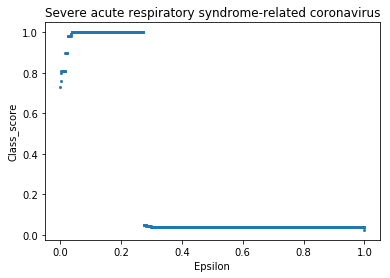

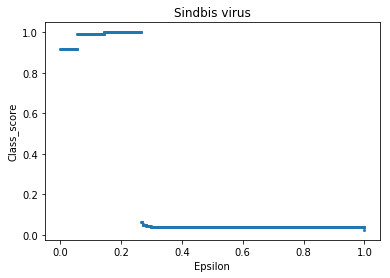

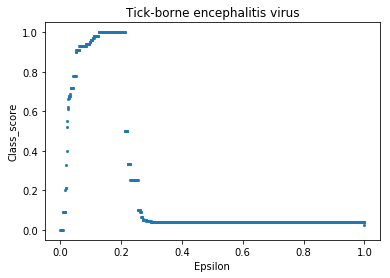

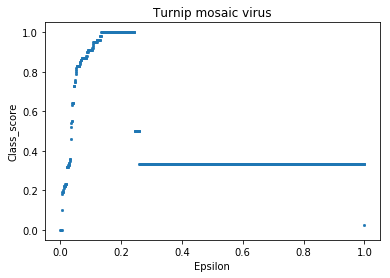

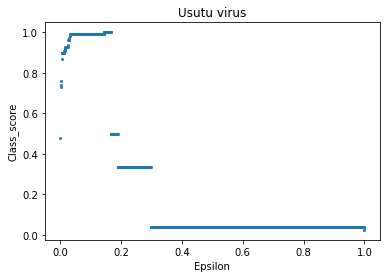

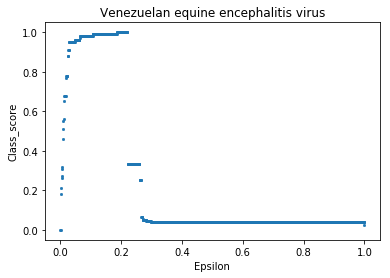

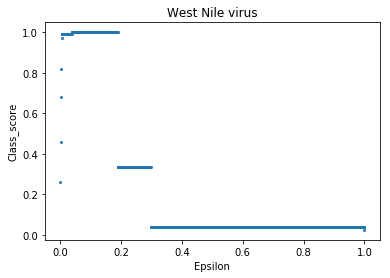

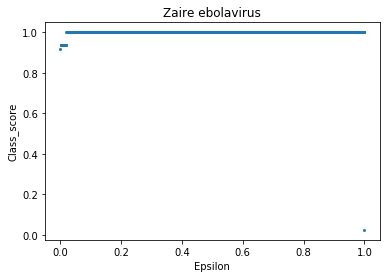

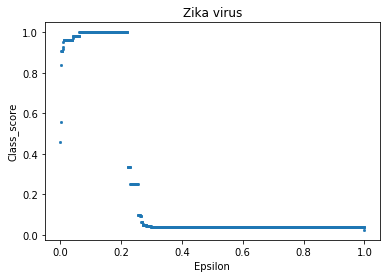

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
for index, data in df_All_Class_metadata[df_All_Class_metadata["Min_group"] == 9].groupby("Class"):
    sns.scatterplot(
                    x=data["Epsilon"], 
                    y=data["Class_score"],
                    s=5,
                    edgecolor=None
                    ).set_title(index)
    plt.show()